# Dall'Asen Nicola (211662 - nicola.dallasen@studenti.unitn.it) - Florence AirBnB Analysis

### Import libraries

In [1]:
import pandas as pd
import geopandas as gpd

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from folium.plugins import BeautifyIcon
import contextily as ctx
from branca.element import Figure
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns

import pyrosm
import osmnx as ox
from shapely.geometry import Point, LineString
import pyproj
from shapely.ops import transform
from owslib.wms import WebMapService

/home/fodark/.pyenv/versions/3.8.6/envs/geospatial/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
wgs84 = pyproj.CRS('EPSG:4326')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

## Analysis

### 1) Choose one of the cities available from the InsideAirbnb

#### Data loading

Extract Florence point using Nominatim for centering maps

In [3]:
geolocator = Nominatim(user_agent="Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko/20100101 Firefox/84.0")
location = geolocator.geocode("Florence, Italy")
city_point = [location.latitude, location.longitude]
city_point

[43.7698712, 11.2555757]

Download airbnb data for Florence and convert them to GeoDataFrame

In [4]:
!curl "http://data.insideairbnb.com/italy/toscana/florence/2020-11-10/visualisations/listings.csv" > "listings.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1575k  100 1575k    0     0  1465k      0  0:00:01  0:00:01 --:--:-- 1465k


In [5]:
df = pd.read_csv("listings.csv")

Filter out relevant columns

In [6]:
df = df[['id', 'name', 'neighbourhood', 'latitude', 'longitude', 'price']]

In [7]:
airbnb_4326 = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [8]:
airbnb_4326.head()

id                                 name   neighbourhood  latitude  \
0  24469  Fortezza/City Centre Modern Apt 2+2  Centro Storico  43.78210   
1  24470  Fortezza/City Centre Modern Apt 2+1  Centro Storico  43.78202   
2  24471  Fortezza/City Centre Modern Apt 4+2  Centro Storico  43.78202   
3  24472  Fortezza/City Centre Modern Apt 4+2  Centro Storico  43.78202   
4  31840     A Residenza Martin  Classic room  Centro Storico  43.77709   

   longitude  price                   geometry  
0   11.24392     70  POINT (11.24392 43.78210)  
1   11.24399     70  POINT (11.24399 43.78202)  
2   11.24399    135  POINT (11.24399 43.78202)  
3   11.24399    120  POINT (11.24399 43.78202)  
4   11.25216     34  POINT (11.25216 43.77709)

Plot the points on a map

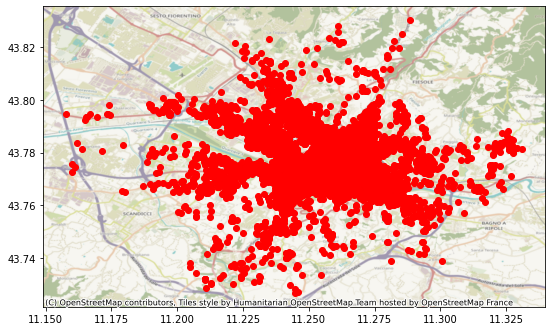

In [9]:
ax = airbnb_4326.plot(color="red", figsize=(9, 9))
ctx.add_basemap(ax,crs=airbnb_4326.crs.to_string(), source=ctx.providers.OpenStreetMap.HOT)

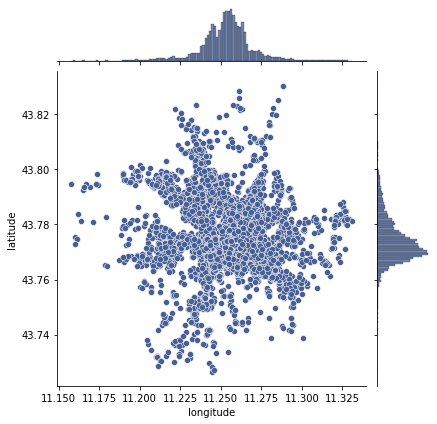

In [10]:
sns.jointplot(x='longitude', y='latitude', color="xkcd:dusky blue", data=airbnb_4326)

The concentrations of structures is in the city center, as shown by the plot above and the table below

In [11]:
neigh_bnb = airbnb_4326.groupby('neighbourhood').id.count().to_frame('number_bnb').reset_index().sort_values(['number_bnb', 'neighbourhood'], ascending=[False, True])
neigh_bnb

neighbourhood  number_bnb
1     Centro Storico        8522
0     Campo di Marte        1188
4            Rifredi         998
3   Isolotto Legnaia         539
2  Gavinana Galluzzo         463

Centro Storico has the most number of AirBnBs, as expected

### 2) Retrieve data on neighborhoods

Download neighborhoods data from AirBnB

In [12]:
!curl "http://data.insideairbnb.com/italy/toscana/florence/2020-11-10/visualisations/neighbourhoods.geojson" > "neighbourhoods.geojson"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86757  100 86757    0     0   123k      0 --:--:-- --:--:-- --:--:--  122k


In [13]:
neighborhoods_4326 = gpd.read_file("neighbourhoods.geojson")

In [14]:
neighborhoods_4326

neighbourhood neighbourhood_group  \
0            Rifredi                None   
1  Gavinana Galluzzo                None   
2     Campo di Marte                None   
3   Isolotto Legnaia                None   
4     Centro Storico                None   

                                            geometry  
0  MULTIPOLYGON (((11.15421 43.78638, 11.15352 43...  
1  MULTIPOLYGON (((11.23119 43.75928, 11.23121 43...  
2  MULTIPOLYGON (((11.27099 43.76490, 11.27116 43...  
3  MULTIPOLYGON (((11.20787 43.74914, 11.20772 43...  
4  MULTIPOLYGON (((11.23119 43.75928, 11.23157 43...

Display them on a map

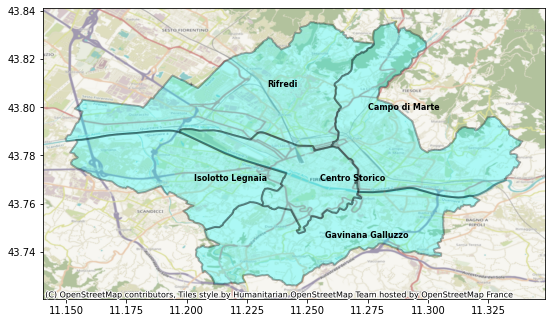

In [15]:
ax = neighborhoods_4326.plot(figsize=(9, 9), facecolor="cyan", alpha=0.3, edgecolor="black", linewidth=2)

texts = []
for p, label in zip(neighborhoods_4326.geometry.representative_point(), neighborhoods_4326.neighbourhood):
    texts.append(plt.text(p.x, p.y, label, fontsize = 8, color="black",fontweight='bold'))

ctx.add_basemap(ax,crs=airbnb_4326.crs.to_string(), source=ctx.providers.OpenStreetMap.HOT)

Download neighborhoods data from Florence data portal

In [16]:
!curl "https://data.comune.fi.it/datastore/download.php?id=7326&type=1&format=csv" > "firenze.zip"
!unzip "firenze.zip"
!cp "./Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/CSV/popolazione_residente_per_quartiere_e_classe_di_eta_31_12_2019.csv" "districts_population.csv" 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  160k  100  160k    0     0   232k      0 --:--:-- --:--:-- --:--:--  232k
Archive:  firenze.zip
  inflating: Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/METADATO_E_LICENZA/Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019.xml  
  inflating: Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/NOTE_LEGALI/Note_legali.txt  
  inflating: Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/METADATO_E_LICENZA/Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019_formatted.xml  
  inflating: Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/METADATO_E_LICENZA/standard_metadata_formatted.css  
  inflating: Popolazione_residente_per_Quartiere_e_per_classe_di_eta_al_31_12_2019/METADATO_E_LICENZA/Licenza_CC-BY-3.0-it.pdf

In [17]:
district_population = pd.read_csv('districts_population.csv', sep=';', encoding="latin-1")
district_population = pd.DataFrame(district_population.iloc[19,1:6])
district_population.rename(columns = {19:'population'}, inplace = True)
district_population.set_index([pd.Index(['Centro Storico', 'Campo di Marte', 'Gavinana Galluzzo', 'Isolotto Legnaia', 'Rifredi'])], inplace=True)
district_population

population
Centro Storico        64.009
Campo di Marte        90.949
Gavinana Galluzzo     40.778
Isolotto Legnaia      68.146
Rifredi              107.908

### 3) View statistical information on neighborhoods

Merge population data with neighborhoods geometries

In [18]:
population_with_geometry = neighborhoods_4326.merge(district_population, left_on='neighbourhood', right_index=True)[['neighbourhood', 'geometry', 'population']]

population_with_geometry = population_with_geometry.to_crs(epsg=3857)
population_with_geometry['centroid'] = population_with_geometry.geometry.centroid
population_with_geometry['geometry'] = population_with_geometry['centroid']
population_with_geometry.drop(['centroid'], axis=1, inplace=True)
population_with_geometry = population_with_geometry.to_crs(epsg=4326)

population_with_geometry['x'] = population_with_geometry.geometry.x
population_with_geometry['y'] = population_with_geometry.geometry.y
population_with_geometry

neighbourhood                   geometry population          x  \
0            Rifredi  POINT (11.22463 43.80493)    107.908  11.224629   
1  Gavinana Galluzzo  POINT (11.25681 43.74704)     40.778  11.256811   
2     Campo di Marte  POINT (11.29304 43.78990)     90.949  11.293043   
3   Isolotto Legnaia  POINT (11.19645 43.77325)     68.146  11.196449   
4     Centro Storico  POINT (11.24429 43.77293)     64.009  11.244285   

           y  
0  43.804925  
1  43.747039  
2  43.789898  
3  43.773246  
4  43.772927

Plot a heatmap of the population for the districts

In [19]:
fig = Figure(width=550,height=350)
map = folium.Map(location=city_point,tiles='cartodbpositron',zoom_start=11)
data = population_with_geometry[['y','x', 'population']]

folium.GeoJson(
    neighborhoods_4326
    ).add_to(map)

HeatMap(data.values).add_to(map)
fig.add_child(map)
map

### 4) Identify which are the neighborhoods with the highest prices in AirBnB

Let's see the price distributions divided by district, *Gavinana Galluzzo* seems to have a different behaviour w.r.t the others.

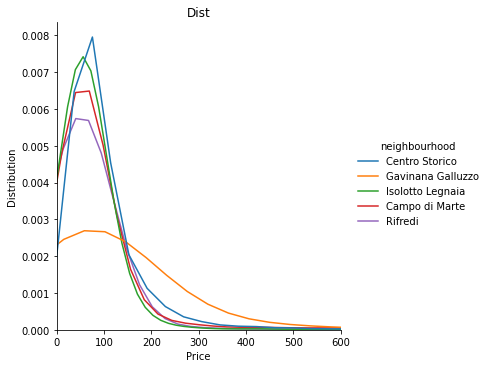

In [20]:
plot = sns.displot(airbnb_4326, x="price", hue="neighbourhood", kind="kde", common_norm=False)
plot = (plot.set_axis_labels("Price","Distribution").set(xlim=(0,600)))
plt.title("Dist")

plt.show(plot)

Calculate mean price grouped by neighborhood

In [21]:
mean_price_neigh = airbnb_4326.groupby(['neighbourhood']).price.mean().to_frame('mean_price').reset_index().sort_values(['mean_price', 'neighbourhood'], ascending=[False, True])
mean_price_neigh

neighbourhood  mean_price
2  Gavinana Galluzzo  143.987041
1     Centro Storico  101.850153
0     Campo di Marte   85.840067
3   Isolotto Legnaia   74.612245
4            Rifredi   73.904810

*Gavinana Galluzzo* has a higher mean price, which is unexpected, let's search for the motivation by looking at the most expensive structures in that district

In [22]:
airbnb_4326.loc[airbnb_4326.neighbourhood=="Gavinana Galluzzo",].sort_values('price', ascending=False).head(10)[['name', 'price']]

name  price
11618                      Dimora Torricella  at Toscana   7889
6441        Florence Villa with with Pool and Big Garden   2700
11091  Villa del Merlo, a magnificent place for holid...   2450
7709        Private  Estate  Pool, sleep 26 WiFi parking   2100
7239   Private Estate Maze garden romantic wedding ev...   1900
2402                                       villa toscana   1700
1912                 7 Bdr Villa, great central location   1000
4181   Luxurious villa with pool 10 minutes from Flor...    988
8793       Florence Apartament | Pool, Gym, Turkish Bath    900
8797   Petit Florence Apartament | Pool, Gym,Turkish ...    900

*Gavinana Galluzzo* contains many expensive villas, which skew the mean towards the high value.

Join these data with the geometries

In [23]:
mean_price = neighborhoods_4326.merge(mean_price_neigh, on='neighbourhood')[['neighbourhood', 'geometry', 'mean_price']]
mean_price = mean_price.to_crs(epsg=3857)
mean_price['centroid'] = mean_price.geometry.centroid
mean_price['geometry'] = mean_price['centroid']
mean_price.drop(['centroid'], axis=1, inplace=True)
mean_price = mean_price.to_crs(epsg=4326)
mean_price

neighbourhood                   geometry  mean_price
0            Rifredi  POINT (11.22463 43.80493)   73.904810
1  Gavinana Galluzzo  POINT (11.25681 43.74704)  143.987041
2     Campo di Marte  POINT (11.29304 43.78990)   85.840067
3   Isolotto Legnaia  POINT (11.19645 43.77325)   74.612245
4     Centro Storico  POINT (11.24429 43.77293)  101.850153

In [24]:
mean_price['x'] = mean_price.geometry.x
mean_price['y'] = mean_price.geometry.y

Display a heatmap for the mean price, we can see higher price areas do not correspond to higher population shown on the previous heatmap, on the contrary, the zone with most of the population, Rifredi, has the lowest mean price. 

In [25]:
fig = Figure(width=550,height=350)
map = folium.Map(location=city_point,tiles='cartodbpositron',zoom_start=11)
data = mean_price[['y','x', 'mean_price']]

folium.GeoJson(
    neighborhoods_4326
    ).add_to(map)

HeatMap(data.values).add_to(map)
fig.add_child(map)
map

### 5) Identify which are the districts with the greatest number of tourist activities

In [26]:
bbox_geom = neighborhoods_4326['geometry'].unary_union

Extract OpenStreetMap data from the file downloaded from BBBike

In [27]:
!wget "https://github.com/Fodark/geospatial-unitn-exam/raw/main/florence.osm.pbf"

--2021-01-12 11:33:34--  https://github.com/Fodark/geospatial-unitn-exam/raw/main/florence.osm.pbf
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Fodark/geospatial-unitn-exam/main/florence.osm.pbf [following]
--2021-01-12 11:33:35--  https://raw.githubusercontent.com/Fodark/geospatial-unitn-exam/main/florence.osm.pbf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8689261 (8.3M) [application/octet-stream]
Saving to: ‘florence.osm.pbf.1’

florence.osm.pbf.1  100%[===================>]   8.29M  6.57MB/s    in 1.3s    

2021-01-12 11:33:37 (6.57 MB/s) - ‘florence.osm.pbf.1’ sav

In [28]:
osm = pyrosm.OSM("florence.osm.pbf",bounding_box=bbox_geom)

Filter out tourism activities

In [29]:
osm.conf.tags.tourism

custom_filter = {'tourism': True}
pois = osm.get_pois(custom_filter=custom_filter)
pois = pois.loc[pois.lat.notnull(),]

Plot them on a map

In [30]:
fig = Figure(width=550,height=350)
map = folium.Map(location=city_point,tiles='cartodbpositron',zoom_start=12)

folium.GeoJson(
    neighborhoods_4326
    ).add_to(map)

folium.GeoJson(
    pois
    ).add_to(map)

map

The figure is not clear, let's plot again with MarkerClusters

In [31]:
def getMarker(lat,lon, message,tip,inconstyle):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=inconstyle)
  return marker

fig = Figure(width=750,height=550)
map = folium.Map(location=city_point,tiles='cartodbpositron',zoom_start=12)

folium.GeoJson(
    neighborhoods_4326
    ).add_to(map)

marker_cluster = MarkerCluster().add_to(map)

for index, row in pois.iterrows():
  icon=folium.Icon(color='purple',prefix='fa',icon='map')
  message = '<strong>'+ str(row['name']) + '</strong>'
  tip = message + '<br/>'
  marker = getMarker(row['lat'],row['lon'],message, tip, icon)
  #add to marker cluster 
  marker.add_to(marker_cluster)
    
fig.add_child(map)
map

The city center clearly has the most points of interest

In [32]:
pois = pois.to_crs(epsg=3857)
pois['centroid'] = pois.geometry.centroid
pois['geometry'] = pois.centroid
pois.drop(['centroid'], axis=1, inplace=True)
pois = pois.to_crs(epsg=4326)

pois['longitude'] = pois.geometry.x
pois['latitude'] = pois.geometry.y

Plot again with a legend grouped by activity type

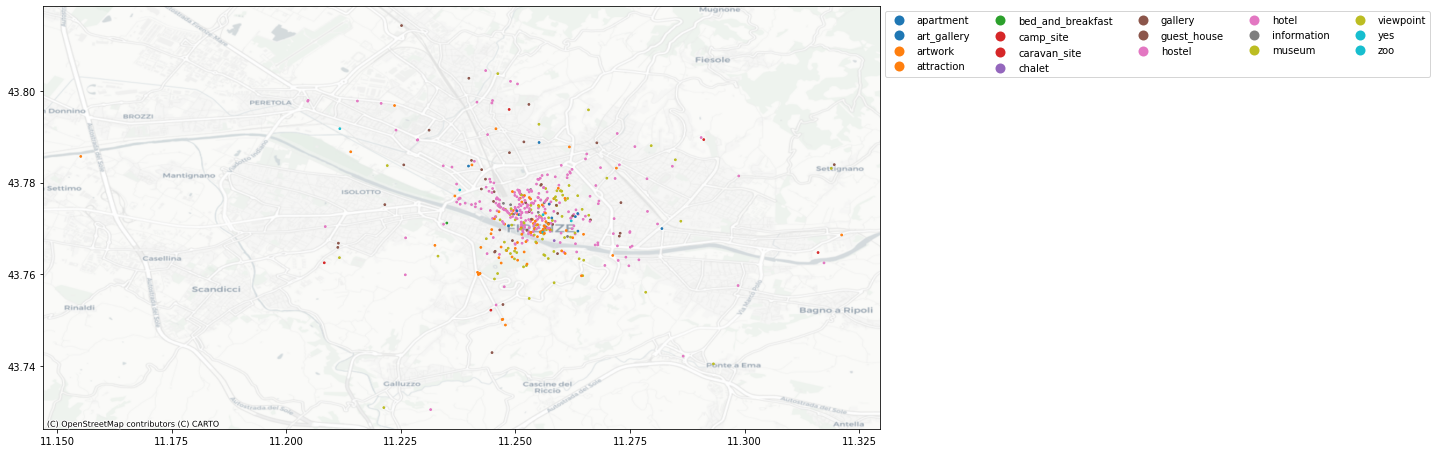

In [33]:
pois["poi_type"] = pois["tourism"]
pois["poi_type"] = pois["poi_type"].fillna(pois["tourism"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(15,15), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
ctx.add_basemap(ax,
      crs=neighborhoods_4326.crs.to_string(),
      source=ctx.providers.CartoDB.Positron)

Let's compute the actual distribution for each neighborhood

In [34]:
tourism_and_districts = gpd.sjoin(neighborhoods_4326, 
                          pois, how='inner', op='contains', lsuffix='districts_', rsuffix='tourism_')

In [35]:
neigh_pois = tourism_and_districts.groupby('neighbourhood').id.count().to_frame('number_tourism').reset_index().sort_values(['number_tourism', 'neighbourhood'], ascending=[False, True])
neigh_pois

neighbourhood  number_tourism
1     Centro Storico             407
0     Campo di Marte              37
4            Rifredi              29
2  Gavinana Galluzzo              16
3   Isolotto Legnaia              11

Centro Storico has the most number of tourism attractions as expected

### 6) Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance)

Let's choose Palazzo Vecchio as our museum

In [36]:
location = geolocator.geocode("Palazzo Vecchio, Florence")
museum_point =  [location.latitude, location.longitude]
                 
museum_point

[43.76916385, 11.256122235407785]

Download OSM routes

In [37]:
G = ox.graph_from_place("Florence, Italy", network_type='walk')

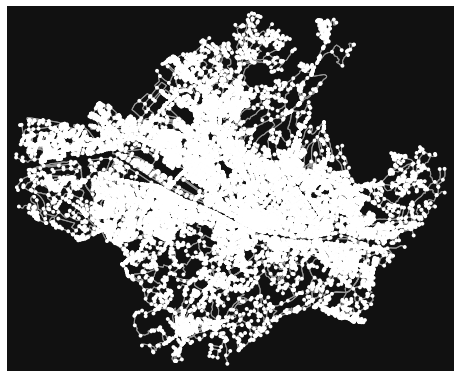

In [38]:
fig, ax = ox.plot_graph(G)

In [39]:
def get_closest_point(G, point):
    return ox.get_nearest_node(G, (point.y, point.x))

airbnb_4326['nearest_point'] = airbnb_4326['geometry'].apply(lambda p: get_closest_point(G, p))

Penalize routes where people cannot walk, i.e. motorways and similars

In [40]:
hwy_walking_speeds = {
    'motorway ': 0.5,
    'trunk': 0.5,
    'primary': 0.5,
    'secondary': 0.5,
    'tertiary': 0.5,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}

G = ox.add_edge_speeds(G,hwy_speeds=hwy_walking_speeds)
G = ox.add_edge_travel_times(G)

In [41]:
point_nearest_museum = ox.get_nearest_node(G, museum_point)

Calculate the route from each BnB to the museum

In [42]:
airbnb_4326['route_from_museum'] = airbnb_4326.nearest_point.apply(lambda to_point: ox.shortest_path(G, point_nearest_museum, to_point))

Calculate the path length and time needed for each BnB to the museum

In [43]:
def travel_time_from_museum(inG, route):
    if len(route) < 2:
        return 0
    
    edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
    return (sum(edge_times))

airbnb_4326['travel_time_from_museum'] = airbnb_4326.route_from_museum.apply(lambda route: travel_time_from_museum(G,route))

In [44]:
def length_path_from_museum(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')
  return (sum(edge_lengths))

airbnb_4326['path_length_from_museum'] = airbnb_4326.route_from_museum.apply(lambda route: length_path_from_museum(G,route))

In [45]:
nearests = airbnb_4326.sort_values(by=['path_length_from_museum']).head(10)[['name', 'geometry', 'path_length_from_museum', 'travel_time_from_museum', 'price']]

In [46]:
nearests

name  \
4390                                   Heart of Florence   
3572                                            Perugino   
10121                                     Uffizi Suite A   
5310                                   La nuova Signoria   
6695         Huge apartment in tourist heart of Florence   
4356                                  Renaissance Beauty   
4863       Studio della Condotta - Piazza della Signoria   
470                        in the very heart of Florence   
3504   Signoria Suite Art Gallery - balcony amazing view   
10450                                     Lambertesca 14   

                        geometry  path_length_from_museum  \
4390   POINT (11.25589 43.76899)                    0.000   
3572   POINT (11.25607 43.76908)                    0.000   
10121  POINT (11.25633 43.76899)                    0.000   
5310   POINT (11.25648 43.76910)                    0.000   
6695   POINT (11.25580 43.76908)                    7.351   
4356   POINT (11.25576 43.76926)                   17.733   
4863   POINT (11.25609 43.76931)                   17.733   
470    POINT (11.25520 43.76944)                   68.582   
3504   POINT (11.25528 43.76941)                   68.582   
10450  POINT (11.25572 43.76837)                   74.150   

       travel_time_from_museum  price  
4390                       0.0   1400  
3572                       0.0    500  
10121                      0.0     85  
5310                       0.0     80  
6695                       7.6     12  
4356                      18.3    170  
4863                      18.3     55  
470                       70.6    150  
3504                      70.6    160  
10450                     76.3     63

Some of them have 0 distance, meaning the nearest point in the graph is the same of the museum's

Let's compute haversine distance for them

In [47]:
shapely_museum_point = Point(museum_point)
point_museum_utm32n = transform(projection_transform,shapely_museum_point)

nearests['haversine_distance_to_museum'] = nearests.geometry.to_crs(epsg=32632).representative_point().distance(point_museum_utm32n)
nearests

name  \
4390                                   Heart of Florence   
3572                                            Perugino   
10121                                     Uffizi Suite A   
5310                                   La nuova Signoria   
6695         Huge apartment in tourist heart of Florence   
4356                                  Renaissance Beauty   
4863       Studio della Condotta - Piazza della Signoria   
470                        in the very heart of Florence   
3504   Signoria Suite Art Gallery - balcony amazing view   
10450                                     Lambertesca 14   

                        geometry  path_length_from_museum  \
4390   POINT (11.25589 43.76899)                    0.000   
3572   POINT (11.25607 43.76908)                    0.000   
10121  POINT (11.25633 43.76899)                    0.000   
5310   POINT (11.25648 43.76910)                    0.000   
6695   POINT (11.25580 43.76908)                    7.351   
4356   POINT (11.25576 43.76926)                   17.733   
4863   POINT (11.25609 43.76931)                   17.733   
470    POINT (11.25520 43.76944)                   68.582   
3504   POINT (11.25528 43.76941)                   68.582   
10450  POINT (11.25572 43.76837)                   74.150   

       travel_time_from_museum  price  haversine_distance_to_museum  
4390                       0.0   1400                     26.884279  
3572                       0.0    500                     10.221793  
10121                      0.0     85                     25.553103  
5310                       0.0     80                     29.666848  
6695                       7.6     12                     27.567395  
4356                      18.3    170                     31.061026  
4863                      18.3     55                     16.444605  
470                       70.6    150                     80.344786  
3504                      70.6    160                     73.121369  
10450                     76.3     63                     93.961421

In haversine distance they are more distant than some on walk distance, let's exclude them

In [48]:
nearests = nearests.loc[(nearests['path_length_from_museum'] > 0.),].head(3)
nearests

name  \
6695    Huge apartment in tourist heart of Florence   
4356                             Renaissance Beauty   
4863  Studio della Condotta - Piazza della Signoria   

                       geometry  path_length_from_museum  \
6695  POINT (11.25580 43.76908)                    7.351   
4356  POINT (11.25576 43.76926)                   17.733   
4863  POINT (11.25609 43.76931)                   17.733   

      travel_time_from_museum  price  haversine_distance_to_museum  
6695                      7.6     12                     27.567395  
4356                     18.3    170                     31.061026  
4863                     18.3     55                     16.444605

In [49]:
y = nearests.geometry.unary_union.centroid.y
x = nearests.geometry.unary_union.centroid.x
geojson = nearests.to_json()

Let's plot them on a map alongside Palazzo Vecchio

In [50]:
map = folium.Map([y,x], zoom_start=21)

def getMarker(lat,lon, message,tip,inconstyle):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=inconstyle)
  return marker

for index, row in nearests.iterrows():
    marker = folium.Marker(location=[row.geometry.y,row.geometry.x], tooltip=row['name'])
    marker.add_to(map)

marker = folium.Marker(location=[museum_point[0],museum_point[1]], icon=folium.Icon(color='purple',prefix='fa',icon='arrow-circle-down'), tooltip="Palazzo Vecchio")
marker.add_to(map)

They are actually extremely close to the museum

### 7) Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m

Extract the required shops from OSM

In [51]:
custom_filter = {'shop': ['supermarket', 'chemist'], 'amenity': ['restaurant', 'pharmacy']}
services = osm.get_pois(custom_filter=custom_filter)

In [52]:
services = services.loc[services.lat.notnull(),]

In [53]:
services_and_districts = gpd.sjoin(neighborhoods_4326, 
                          services, how='inner', op='contains', lsuffix='districts_', rsuffix='tourism_')
neigh_services = services_and_districts.groupby('neighbourhood').id.count().to_frame('number_services').reset_index().sort_values(['number_services', 'neighbourhood'], ascending=[False, True])
neigh_services

neighbourhood  number_services
1     Centro Storico              585
0     Campo di Marte              104
4            Rifredi               91
2  Gavinana Galluzzo               43
3   Isolotto Legnaia               41

Plot them, given the high number let's use marker clusters

In [54]:
def getMarker(lat, lon, message, tip, inconstyle):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=inconstyle)
  return marker

fig = Figure(width=750,height=550)
map = folium.Map(location=city_point,tiles='cartodbpositron',zoom_start=12)

folium.GeoJson(
    neighborhoods_4326
    ).add_to(map)

marker_cluster = MarkerCluster().add_to(map)

for index, row in services.iterrows():
  icon=folium.Icon(color='purple',prefix='fa',icon='building')
  message = '<strong>'+ str(row['name']) + '</strong>'
  tip = message + '<br/>'
  marker = getMarker(row['lat'],row['lon'],message, tip, icon)
  #add to marker cluster 
  marker.add_to(marker_cluster)
    
fig.add_child(map)
map

Compute the 300 meters buffer around the BnBs, after converting to a suitable projection

In [55]:
nearests_32632 = nearests.to_crs(epsg=32632)

In [56]:
nearests_32632['geometry'] = nearests_32632.buffer(300)

Spatially join the buffers and the services

In [57]:
services_in_bnb = gpd.sjoin(nearests_32632, services.to_crs(epsg=32632), how='inner', op='contains', lsuffix='bnb', rsuffix='service')

In [58]:
services_in_bnb.head()

name_bnb  \
6695  Huge apartment in tourist heart of Florence   
4356                           Renaissance Beauty   
6695  Huge apartment in tourist heart of Florence   
4356                           Renaissance Beauty   
6695  Huge apartment in tourist heart of Florence   

                                               geometry  \
6695  POLYGON ((681858.823 4848698.631, 681857.378 4...   
4356  POLYGON ((681855.058 4848718.535, 681853.614 4...   
6695  POLYGON ((681858.823 4848698.631, 681857.378 4...   
4356  POLYGON ((681855.058 4848718.535, 681853.614 4...   
6695  POLYGON ((681858.823 4848698.631, 681857.378 4...   

      path_length_from_museum  travel_time_from_museum  price  \
6695                    7.351                      7.6     12   
4356                   17.733                     18.3    170   
6695                    7.351                      7.6     12   
4356                   17.733                     18.3    170   
6695                    7.351                      7.6     12   

      haversine_distance_to_museum  index_service        lon  tags  changeset  \
6695                     27.567395            219  11.254338  None        0.0   
4356                     31.061026            219  11.254338  None        0.0   
6695                     27.567395            442  11.253951  None        0.0   
4356                     31.061026            442  11.253951  None        0.0   
6695                     27.567395            227  11.254027  None        0.0   

      ...  shop     amenity   bar  building:levels internet_access  \
6695  ...  None  restaurant  None             None            None   
4356  ...  None  restaurant  None             None            None   
6695  ...  None  restaurant  None             None            None   
4356  ...  None  restaurant  None             None            None   
6695  ...  None  restaurant  None             None            None   

                 source wikipedia osm_type building landuse  
6695  Comune di Firenze      None     node      NaN     NaN  
4356  Comune di Firenze      None     node      NaN     NaN  
6695               None      None     node      NaN     NaN  
4356               None      None     node      NaN     NaN  
6695  Comune di Firenze      None     node      NaN     NaN  

[5 rows x 37 columns]

Calculate the number of services inside the area of each BnB, since their closeness it is expected from them to have similar if not equal numbers

In [59]:
services_in_bnb.groupby('name_bnb').size().to_frame("services_count").sort_values(['services_count', 'name_bnb'], ascending=[False,True])

services_count
name_bnb                                                     
Renaissance Beauty                                         98
Huge apartment in tourist heart of Florence                96
Studio della Condotta - Piazza della Signoria              96

In [60]:
def getMarker(lat, lon, message, tip,icon):
  marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=icon)
  return marker

fig = Figure(width=750,height=550)
map = folium.Map(location=museum_point,tiles='cartodbpositron',zoom_start=16)

folium.GeoJson(
    nearests_32632
    ).add_to(map)

folium.GeoJson(
    services
    ).add_to(map)

for index, row in nearests.iterrows():
    icon = folium.Icon(color='purple',prefix='fa',icon='arrow-circle-down')
    marker = folium.Marker(location=[row.geometry.y ,row.geometry.x], tooltip=row['name'], icon=icon)
    marker.add_to(map)
    
fig.add_child(map)
map

Since they are extremely close we see the three areas cover more or less the same portion, except for a point to the north-east which is included only in one of the areas

### 8) Analyze and test spatial autocorrelation of price

Let's start by creating a new GeoDataFrame that holds the data needed for the spatial autocorrelation and regression analysis
For each neighborhood we are going to keep the number of AirBnBs, the population and the number of tourism POIs, and we are going to see if they can explain the mean price of the area and of the neighbours.

In [61]:
out = neighborhoods_4326.merge(neigh_bnb, left_on='neighbourhood', right_on='neighbourhood')
out = out.merge(mean_price_neigh, on='neighbourhood')
out = out.merge(district_population, left_on='neighbourhood', right_index=True)
out = out.merge(neigh_pois, on='neighbourhood')
out = out.merge(neigh_services, on='neighbourhood')
out.drop(['neighbourhood_group'], axis=1, inplace=True)
out = gpd.GeoDataFrame(out, crs="EPSG:4326")
out

neighbourhood                                           geometry  \
0            Rifredi  MULTIPOLYGON (((11.15421 43.78638, 11.15352 43...   
1  Gavinana Galluzzo  MULTIPOLYGON (((11.23119 43.75928, 11.23121 43...   
2     Campo di Marte  MULTIPOLYGON (((11.27099 43.76490, 11.27116 43...   
3   Isolotto Legnaia  MULTIPOLYGON (((11.20787 43.74914, 11.20772 43...   
4     Centro Storico  MULTIPOLYGON (((11.23119 43.75928, 11.23157 43...   

   number_bnb  mean_price population  number_tourism  number_services  
0         998   73.904810    107.908              29               91  
1         463  143.987041     40.778              16               43  
2        1188   85.840067     90.949              37              104  
3         539   74.612245     68.146              11               41  
4        8522  101.850153     64.009             407              585

Save it in the shapefile format in order to be read by R

In [62]:
!mkdir -p florence_shp
out.to_file("florence_shp/districts.shp")

Load the extension that enables R code to be written inside a Jupyter notebook

In [63]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

Load the data and convert the needed columns

In [64]:
%%R
library(spdep); library(rgdal)
florence <- readOGR("florence_shp","districts")
florence$number_bnb <- as.numeric(florence$number_bnb)
florence$population <- as.numeric(florence$population)
florence$number_tou <- as.numeric(florence$number_tou)
florence$number_ser <- as.numeric(florence$number_ser)
print(summary(florence))
coords <- coordinates(florence)

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.8.1, GDAL 3.0.4, PROJ 6.3.2

R[write to console]: rgdal: version: 1.5-19, (SVN revision 1092)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /home/fodark/.pyenv/versions/3.8.6/envs/geospatial/lib/python3.8/site-packages/fiona/gdal_data
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.2, May 1st, 2020, [PJ_VERSION: 632]
Path to PROJ shared files: /usr/share/proj
Linking to sp version:1.4-4
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportT

OGR data source with driver: ESRI Shapefile 
Source: "/home/fodark/university/dallasen-211662-exam/florence_shp", layer: "districts"
with 5 features
It has 6 fields
Integer64 fields read as strings:  number_bnb number_tou number_ser 
Object of class SpatialPolygonsDataFrame
Coordinates:
       min      max
x 11.14975 11.33901
y 43.72600 43.83548
Is projected: FALSE 
proj4string : [+proj=longlat +datum=WGS84 +no_defs]
Data attributes:
  neighbourh          number_bnb     mean_price       population    
 Length:5           Min.   : 463   Min.   : 73.90   Min.   : 40.78  
 Class :character   1st Qu.: 539   1st Qu.: 74.61   1st Qu.: 64.01  
 Mode  :character   Median : 998   Median : 85.84   Median : 68.15  
                    Mean   :2342   Mean   : 96.04   Mean   : 74.36  
                    3rd Qu.:1188   3rd Qu.:101.85   3rd Qu.: 90.95  
                    Max.   :8522   Max.   :143.99   Max.   :107.91  
   number_tou    number_ser   
 Min.   : 11   Min.   : 41.0  
 1st Qu.: 16   1s

#### Global effect

Let's find the minimum minimum threshold distance such that every region has at least one neighbor

In [65]:
%%R
knn1IT <- knn2nb(knearneigh(coords,k=1,longlat=T))
all.linkedT <- max(unlist(nbdists(knn1IT, coords, longlat=T))) 
all.linkedT

[1] 4.354189


We build three different distances in order to have an increasing number of neighbors

In [66]:
%%R
dnb436 <- dnearneigh(coords, 0, 4.36, longlat=TRUE)
dnb636 <- dnearneigh(coords, 0, 6.36, longlat=TRUE)
dnb10 <- dnearneigh(coords, 0, 10, longlat=TRUE)

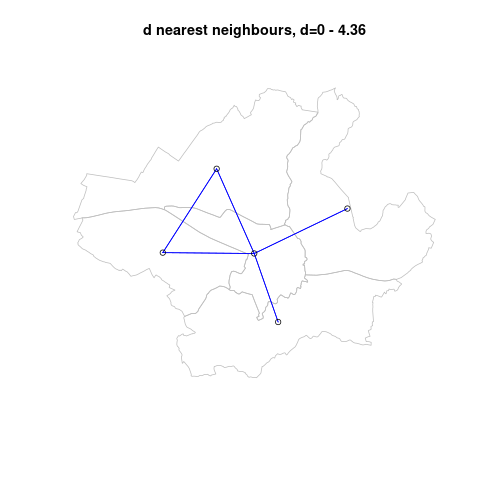

In [67]:
%%R
plot(florence, border="grey",xlab="",ylab="",xlim=NULL)
title(main="d nearest neighbours, d=0 - 4.36") 
plot(dnb436, coords, add=TRUE, col="blue")

Create a row-standardized spatial weights matrix for each critical cut-off neighbours

In [68]:
%%R
dnb436.listw <- nb2listw(dnb436,style="W")
dnb636.listw <- nb2listw(dnb636,style="W")
dnb10.listw <- nb2listw(dnb10,style="W")

Apply the test to the growth rate with different specifications of the spatial weights matrix (under the assumption of normality)

In [69]:
%%R
print(moran.test(florence$mean_price, dnb436.listw, randomisation=FALSE))
print(moran.test(florence$mean_price, dnb636.listw, randomisation=FALSE))
print(moran.test(florence$mean_price, dnb10.listw, randomisation=FALSE))


	Moran I test under normality

data:  florence$mean_price  
weights: dnb436.listw    

Moran I statistic standard deviate = 1.5592, p-value = 0.05947
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.16498637       -0.25000000        0.07083333 


	Moran I test under normality

data:  florence$mean_price  
weights: dnb636.listw    

Moran I statistic standard deviate = 0.52288, p-value = 0.3005
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.16656318       -0.25000000        0.02546296 


	Moran I test under normality

data:  florence$mean_price  
weights: dnb10.listw    

Moran I statistic standard deviate = NaN, p-value = NA
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
            -0.25             -0.25              0.00 



Only the first test with the minimum distance has a statistical significance, although it is low (10%)

Apply the test to the mean price with different specifications of the spatial weights matrix (under the assumption of randomisation)

In [70]:
%%R
print(moran.test(florence$mean_price, dnb436.listw, randomisation=T))
print(moran.test(florence$mean_price, dnb636.listw, randomisation=T))
print(moran.test(florence$mean_price, dnb10.listw, randomisation=T))


	Moran I test under randomisation

data:  florence$mean_price  
weights: dnb436.listw    

Moran I statistic standard deviate = 1.583, p-value = 0.05671
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.16498637       -0.25000000        0.06872028 


	Moran I test under randomisation

data:  florence$mean_price  
weights: dnb636.listw    

Moran I statistic standard deviate = 0.66302, p-value = 0.2537
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.16656318       -0.25000000        0.01583682 


	Moran I test under randomisation

data:  florence$mean_price  
weights: dnb10.listw    

Moran I statistic standard deviate = NaN, p-value = NA
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
            -0.25             -0.25              0.00 



Also under this assumption the only relevant model is the first

Apply the test to the growth rate with different specifications of the spatial weights matrix (under permutation bootstrap)

In [71]:
%%R
print(moran.mc(florence$mean_price, dnb436.listw, nsim=99))
print(moran.mc(florence$mean_price, dnb636.listw, nsim=99))
print(moran.mc(florence$mean_price, dnb10.listw, nsim=99))


	Monte-Carlo simulation of Moran I

data:  florence$mean_price 
weights: dnb436.listw  
number of simulations + 1: 100 

statistic = 0.16499, observed rank = 97, p-value = 0.03
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  florence$mean_price 
weights: dnb636.listw  
number of simulations + 1: 100 

statistic = -0.16656, observed rank = 73, p-value = 0.27
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  florence$mean_price 
weights: dnb10.listw  
number of simulations + 1: 100 

statistic = -0.25, observed rank = 50.5, p-value = 0.495
alternative hypothesis: greater



Bootstrap confirms it again.

The Moran's I test can also be used in the OLS residuals 

If number of services was to be included in the model, the morantest would break

In [72]:
%%R
LinearSolow <- lm(mean_price ~ number_bnb + number_tou, florence)
print(summary(LinearSolow))


Call:
lm(formula = mean_price ~ number_bnb + number_tou, data = florence)

Residuals:
      0       1       2       3       4 
 -2.366   9.709  15.568 -21.874  -1.037 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) 163.97957   30.01150   5.464   0.0319 *
number_bnb   -0.21331    0.08589  -2.484   0.1310  
number_tou    4.31622    1.73254   2.491   0.1304  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.27 on 2 degrees of freedom
Multiple R-squared:  0.7573,	Adjusted R-squared:  0.5146 
F-statistic:  3.12 on 2 and 2 DF,  p-value: 0.2427



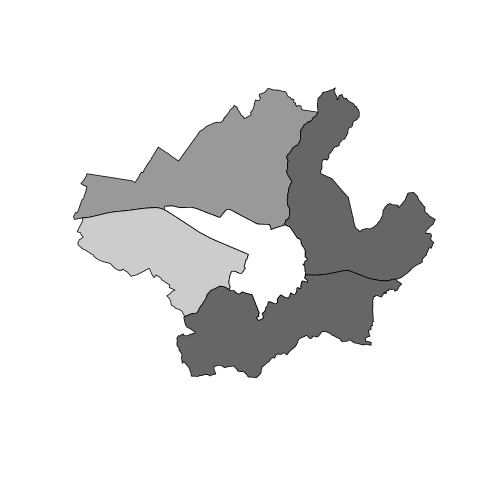

In [73]:
%%R
#The plot of the studentized residuals can give a hint 
#about the presence of spatial dependence in the residuals,
studres <- rstudent(LinearSolow)
resdistr <- quantile(studres, na.rm=T) 
colours <- grey((length(resdistr):2)/length(resdistr))
plot(florence, col=colours[findInterval(studres, resdistr, all.inside=TRUE)]) 

In [74]:
%%R
print(lm.morantest(LinearSolow,dnb436.listw,resfun=rstudent, zero.policy=T))
print(lm.morantest(LinearSolow,dnb636.listw,resfun=rstudent, zero.policy=T))
print(lm.morantest(LinearSolow,dnb10.listw,resfun=rstudent, zero.policy=T))


	Global Moran I for regression residuals

data:  
model: lm(formula = mean_price ~ number_bnb + number_tou, data =
florence)
weights: dnb436.listw

Moran I statistic standard deviate = -1.4876, p-value = 0.9316
alternative hypothesis: greater
sample estimates:
Observed Moran I      Expectation         Variance 
     -0.47510015      -0.12784287       0.05449394 


	Global Moran I for regression residuals

data:  
model: lm(formula = mean_price ~ number_bnb + number_tou, data =
florence)
weights: dnb636.listw

Moran I statistic standard deviate = 0.34321, p-value = 0.3657
alternative hypothesis: greater
sample estimates:
Observed Moran I      Expectation         Variance 
     -0.20490008      -0.27041144       0.03643483 


	Global Moran I for regression residuals

data:  
model: lm(formula = mean_price ~ number_bnb + number_tou, data =
florence)
weights: dnb10.listw

Moran I statistic standard deviate = 231486, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Obser

The Spatial Auto Correlation found in the residuals can be conducted to the erroneous model and not to an actual SAC in the residuals.

#### Local effect

Local spatial autocorrelation can be investigated by the Moran scatterplot and the local Moran's I.  

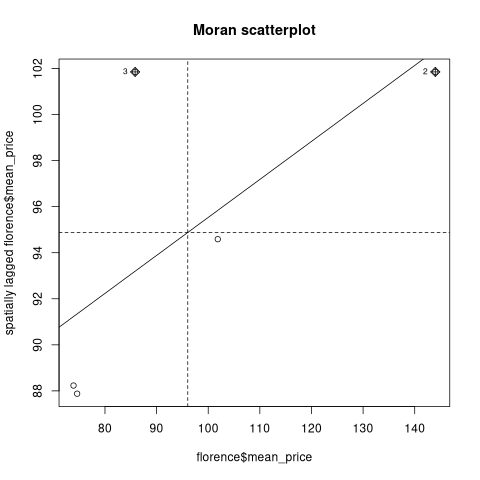

In [75]:
%%R
mplot <- moran.plot(florence$mean_price, listw=dnb436.listw, main="Moran scatterplot", 
         return_df=F)

The plot suggests us a lack of local spatial autocorrelation, let's compute the significance of the revealed pattern by relying on the so-called local Moran's I index.

In [76]:
%%R
lmI <- localmoran(florence$mean_price, dnb436.listw)
print(head(lmI))
lmI <- localmoran(florence$mean_price, dnb636.listw)
print(head(lmI))
lmI <- localmoran(florence$mean_price, dnb10.listw)
print(head(lmI))

          Ii  E.Ii     Var.Ii      Z.Ii Pr(z > 0)
1  0.2552036 -0.25 0.24970278 1.0110084 0.1560062
2  0.4114806 -0.25 0.56071670 0.8833756 0.1885167
3 -0.0875238 -0.25 0.56071670 0.2169791 0.4141123
4  0.2582392 -0.25 0.24970278 1.0170831 0.1545569
5 -0.0124678 -0.25 0.09419583 0.7739389 0.2194835
          Ii  E.Ii     Var.Ii       Z.Ii  Pr(z > 0)
1  0.2812561 -0.25 0.14603148  1.3902108 0.08223244
2 -0.6092745 -0.25 0.14603148 -0.9401631 0.82643305
3 -0.1587701 -0.25 0.14603148  0.2387339 0.40565596
4 -0.3335595 -0.25 0.14603148 -0.2186618 0.58654323
5 -0.0124678 -0.25 0.09419583  0.7739389 0.21948347
          Ii  E.Ii     Var.Ii       Z.Ii Pr(z > 0)
1 -0.1808701 -0.25 0.09419583  0.2252425 0.4108953
2 -0.8487680 -0.25 0.09419583 -1.9509349 0.9744676
3 -0.0384010 -0.25 0.09419583  0.6894421 0.2452726
4 -0.1694931 -0.25 0.09419583  0.2623114 0.3965407
5 -0.0124678 -0.25 0.09419583  0.7739389 0.2194835


The significance is negligible for every neighbor for every cut-off distance, so no local autocorrelation can be found.